<a href="https://colab.research.google.com/github/drscicomm/food-security/blob/main/Gensim_LDA_FromImpossible_All_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive and Upload Text Corpus

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Upload Files

In [ ]:
from google.colab import files
# upload file
uploaded = files.upload()

In [ ]:
import pandas as pd

In [ ]:
# Read data into dataframe
df = pd.read_csv('/content/fromImpossibleFoods_all_temporal.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22976 entries, 0 to 22975
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  22976 non-null  object
 1   Date      22976 non-null  object
 2   Month     22976 non-null  int64 
 3   Day       22976 non-null  int64 
 4   Year      22976 non-null  int64 
 5   Time      22976 non-null  object
 6   tweet     22976 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.2+ MB


In [ ]:
df.drop_duplicates(subset='tweet',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22825 entries, 0 to 22977
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    22825 non-null  object
 1   Month   22825 non-null  object
 2   Day     22825 non-null  object
 3   Year    22825 non-null  object
 4   Time    22824 non-null  object
 5   tweet   22825 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [ ]:
df.head()

,Datetime,Date,Month,Day,Year,Time,tweet
0,2017-02-01 22:07:28+00:00,2/1/2017,2,1,2017,22:07:28+00:00,@DonGordon5 we'd love to hear what you think o...
1,2016-08-01 05:13:16+00:00,8/1/2016,8,1,2016,05:13:16+00:00,"@steuartrhys you don't have to go far, we're c..."
2,2016-08-03 21:34:47+00:00,8/3/2016,8,3,2016,21:34:47+00:00,@YaseminDenari so great to meet you! glad you ...
3,2016-08-05 19:12:49+00:00,8/5/2016,8,5,2016,19:12:49+00:00,@forkingtasty thanks for the article! email he...
4,2016-08-05 01:28:22+00:00,8/5/2016,8,5,2016,01:28:22+00:00,"@Drcmac we're launching in SF this fall, stay ..."


Set up environment

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['https','http'])

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
pip install openpyxl==3.0.7

In [ ]:
import os

os.chdir('..')

#Preprocessing

In [ ]:
#drop spaces
df = df.dropna(subset=['tweet'])

In [ ]:
# Remove punctuation
df['text_processed'] = \
df['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['text_processed'] = \
df['text_processed'].map(lambda x: x.lower())

# Print out the first rows of df
df['text_processed'].head()

0    @dongordon5 we'd love to hear what you think o...
1    @steuartrhys you don't have to go far we're co...
2    @yasemindenari so great to meet you glad you e...
3    @forkingtasty thanks for the article email hel...
4    @drcmac we're launching in sf this fall stay t...
Name: text_processed, dtype: object

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.tweet.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:5])

[['wed', 'love', 'to', 'hear', 'what', 'you', 'think', 'once', 'you', 'have', 'chance', 'to', 'try', 'it'], ['you', 'dont', 'have', 'to', 'go', 'far', 'were', 'coming', 'to', 'sf', 'next'], ['so', 'great', 'to', 'meet', 'you', 'glad', 'you', 'enjoyed', 'our', 'meat', 'on', 'mission'], ['thanks', 'for', 'the', 'article', 'email', 'next', 'time', 'amp', 'well', 'save', 'you', 'hours', 'of', 'google', 'searching', 'for', 'heme'], ['were', 'launching', 'in', 'sf', 'this', 'fall', 'stay', 'tuned', 'for', 'updates']]


Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build Base LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                            eta='auto',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


#Evaluation

## method 1

In [ ]:
coherence = []
for k in range(2,30):
    print('Round: '+str(k))
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           num_topics=k,
                                           passes=10, 
                                           iterations=100,
                                           chunksize=100,
                                           eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=lda_model, texts=data_ready,\
         dictionary=id2word, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29


In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

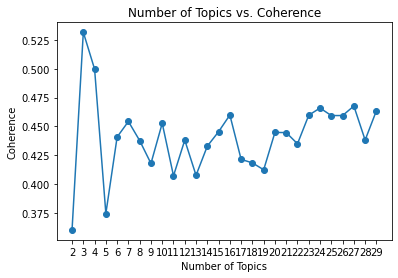

In [ ]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

## Method 2 Determine optimal number of topics, *c_v*

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 25
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus,  int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_all_temporal.csv', index=False)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
1200it [10:46:07, 32.31s/it]


In [ ]:
!cp lda_tuning_results_all_temporal.csv "/content/gdrive/MyDrive"

In [ ]:
# coherence scores, alpha and beta set at .01
# upload file
from google.colab import files
uploaded = files.upload()

Saving coherence 2020.xlsx to coherence 2020.xlsx


In [ ]:
# Read data into dataframe
coherence_topics = pd.read_excel('/coherence 2020.xlsx')

In [ ]:
coherence_topics.head()

In [ ]:
# Show graph

coherence_topics.plot(x ='Topics', y='Coherence', kind = 'line')
plt.title('Topic coherence')
x = np.random.randint(low=10, high=30, size=16)
plt.xticks(np.arange(0, len(x)+1, 2))

In [ ]:
# select best alpha and beta parameters ( for k = 9, look at highest coherence score and select corresponding alpha and beta)
uploaded = files.upload()

Saving alpha-beta-select.xlsx to alpha-beta-select.xlsx


In [ ]:
# Read data into dataframe
best_alphabeta = pd.read_excel('/alpha-beta-select.xlsx')

In [ ]:
best_alphabeta.head()

Choosing Alpha=.61, Beta=.91 k=25
Second best, k = 15, Alpha=asymmetric, Beta=.31

#Build the topic model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



In [ ]:
import seaborn as sns

In [ ]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq

In [ ]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


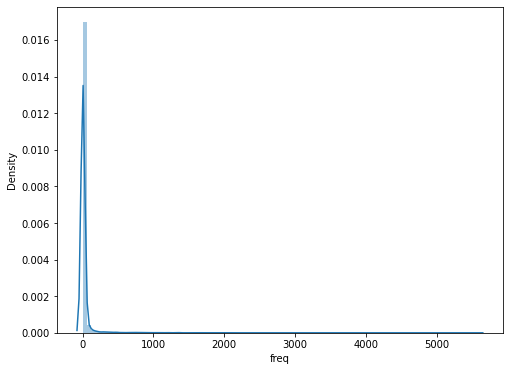

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [ ]:
dict_df.sort_values('freq', ascending=False).head(20)

,freq
impossible,5569
burger,3970
co,3804
thank,3483
make,2989
hear,2688
love,2040
look,1843
come,1780
stay,1659


In [ ]:
extension = dict_df[dict_df.freq>3800].index.tolist()

In [ ]:
extension

['co', 'burger', 'impossible']

In [ ]:
stop_words.extend(extension)

In [ ]:
data_ready = process_words(data)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 11581


In [ ]:
# Filter out words that occur less than 10 documents, or more than 50% of the documents.

id2word.filter_extremes(no_below=10, no_above=0.5)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1128


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#download mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-01-03 18:52:22--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-01-03 18:52:23--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.0MB/s    in 1.4s    

2022-01-03 18:52:24 (11.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
# unzip mallet
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [ ]:
mallet_path = '/mallet-2.0.8/bin/mallet'

In [ ]:
# Build LDA model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=30, id2word=id2word)

In [ ]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(16,
  [('location', 0.19995481247175778),
   ('find', 0.15454134658834162),
   ('website', 0.14369633981021238),
   ('serve', 0.08133755083596927),
   ('list', 0.06235878897424311),
   ('check', 0.06190691369182106),
   ('eye', 0.0298237686398554),
   ('full', 0.022141888838680523),
   ('growing_list', 0.02010845006778129),
   ('sizzle', 0.019882512426570267)]),
 (12,
  [('recipe', 0.17126931846972385),
   ('check', 0.10869014441347859),
   ('restaurant', 0.10286293387382822),
   ('serve', 0.08082087661515075),
   ('find', 0.08056751963516595),
   ('worry', 0.02482898403851026),
   ('add', 0.023562199138586266),
   ('locator', 0.021281986318723082),
   ('original', 0.017481631618951103),
   ('nutritious', 0.016721560678996706)]),
 (4,
  [('people', 0.14466363176530095),
   ('product', 0.0834597875569044),
   ('continue', 0.08244815376833586),
   ('ingredient', 0.07486090035407182),
   ('launch', 0.06322711178553364),
   ('forward', 0.05083459787556904),
   ('comply', 0.03439554881133

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.4592374971752226


In [ ]:
import pickle
pickle.dump(ldamallet, open("/content/gdrive/MyDrive/ldamallet.pkl", "wb"))

In [ ]:
ldamallet = pickle.load(open("/content/gdrive/MyDrive/ldamallet.pkl", "rb"))

In [ ]:
tm = ldamallet[corpus[1]]
tm

[(0, 0.03333333333333333),
 (1, 0.03333333333333333),
 (2, 0.03333333333333333),
 (3, 0.03333333333333333),
 (4, 0.03333333333333333),
 (5, 0.03333333333333333),
 (6, 0.03333333333333333),
 (7, 0.03333333333333333),
 (8, 0.03333333333333333),
 (9, 0.03333333333333333),
 (10, 0.03333333333333333),
 (11, 0.03333333333333333),
 (12, 0.03333333333333333),
 (13, 0.03333333333333333),
 (14, 0.03333333333333333),
 (15, 0.03333333333333333),
 (16, 0.03333333333333333),
 (17, 0.03333333333333333),
 (18, 0.03333333333333333),
 (19, 0.03333333333333333),
 (20, 0.03333333333333333),
 (21, 0.03333333333333333),
 (22, 0.03333333333333333),
 (23, 0.03333333333333333),
 (24, 0.03333333333333333),
 (25, 0.03333333333333333),
 (26, 0.03333333333333333),
 (27, 0.03333333333333333),
 (28, 0.03333333333333333),
 (29, 0.03333333333333333)]

In [ ]:
tm_results = ldamallet[corpus]

In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=30)] for n in range(0, ldamallet.num_topics)]

# Topic Analysis

In [ ]:
#Below is the Topic-Term matrix shows 10 terms that forms each topic.
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 31)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Term1,food,year,article,beef,people,restaurant,feedback,make,whopper,safety,enjoy,restaurant,recipe,taste,product,store,location,learn,meat,future,work,today,good,stay,share,support,retail,hear,grow,give
Term2,safety,hope,business,cook,product,back,share,goal,time,eat,happy,team,check,part,meat,grocery,find,heme,animal,include,make,cookimpossible,great,tune,impossiblefood,delicious,enter,love,forward,hear
Term3,consumer,world,read,conventional,continue,partner,time,accessible,order,test,hear,share,restaurant,information,plant,year,website,soy,cow,big,hard,start,sound,news,experience,wait,month,chance,continue,love
Term4,issue,wait,claim,opportunity,ingredient,stock,improve,plant,area,product,glad,plant_based,serve,excited,plan,detail,serve,protein,mission,event,patience,chef,thing,update,send,kind,expand,give,bring,amazing
Term5,number,lot,mislead,ground,launch,production,reach,sausage,slider,food,drool,option,find,decision,year,retail,list,make,planet,eat,meantime,join,friend,timeline,connect,future,scale,end,early,decide


In [ ]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"food, safety, consumer, issue, number, notify, priority, risk, assessment, operator, talk, consume, process, pic, global, review, human, donate, catch, perspective, buy, consumption, comfortable, leftover, research, fight, respect, pay, dedicate, cookbook"
Topic2,"year, hope, world, wait, lot, home, ground, change, fan, launch, spread, cover, word, long, rest, grind, ability, ready, internationally, focus, north, neighbor, snack, wide, initial, curious, head, blush, sweden, askimpossible"
Topic3,"article, business, read, claim, mislead, homework, safe, fact, record, pesticide, post, extraordinary, inaccurate, levels_accepted, absent, foods_correct, disingenuous, truth, line, final, transparency, peta, prioritize, correct, verdict, present, reference, response, wrong, ensure"
Topic4,"beef, cook, conventional, opportunity, ground, company, accommodate, call, participate, recommend, confirm, request, day, cooking, packaging, cashier, package, open, cheese, reduce, mind, investor, level, special_order, low, invest, traditional, comparable, tray, recyclable"
Topic5,"people, product, continue, ingredient, launch, forward, comply, ensure, food, plan, confidence, regulations_goe, inspire, receive, bold_mission, pursue, safety, top, regulation, sold_include, plant_based, onion, slice, pickle, released, pepper, toast, transparent, derive, lettuce"
Topic6,"restaurant, back, partner, stock, production, demand, ramp, high, menu, temporarily, ramping, result, temporary, supply, asap, due, type, frustration_due, exceed, disappointment, clock, awesome, board, single_partner, shortage, frustration, growth, situation, bit, successfully"
Topic7,"feedback, share, time, improve, reach, lover, work, meet, fellow, hesitate, experience, expectation, additional, resource, sharing, provide, hearing, education, thought, valuable, perspective, utilize, incorporate, crucial, contribution, input, incredibly, continually, attention, versatile"
Topic8,"make, goal, accessible, plant, sausage, absolutely, hit, forget, working, chicken_nugget, blush, confused, albertson, widely, recommendation, detail, von, match, ordering, affordable, kit, ddfairchild, grandma_house, service, short, russellholly, tired, beauty, determined, taytheveg"
Topic9,"whopper, time, order, area, slider, favorite, day, head, king, local, limited, menu, select, nationwide, hand, watch, purchase, game, deliver, delivery, whitecastle, forget, burgerke, exclusively, listen, tastebud, grab, classic, pizza, nice"
Topic10,"safety, eat, test, product, food, question, page, state, rigorously, test_data, totally_safe, stateside, free, genealogy, lunch, iamforanimal, candiphantom, teamparlay, paleophile, imaplacebo, sorcery, lfjgill, big, nzingha, monitor, bendejo, realize, yellow, candid, reevynap"


# Wordclouds

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [ ]:
plt.rcParams['figure.figsize'] = [30, 15]

ValueError: ignored

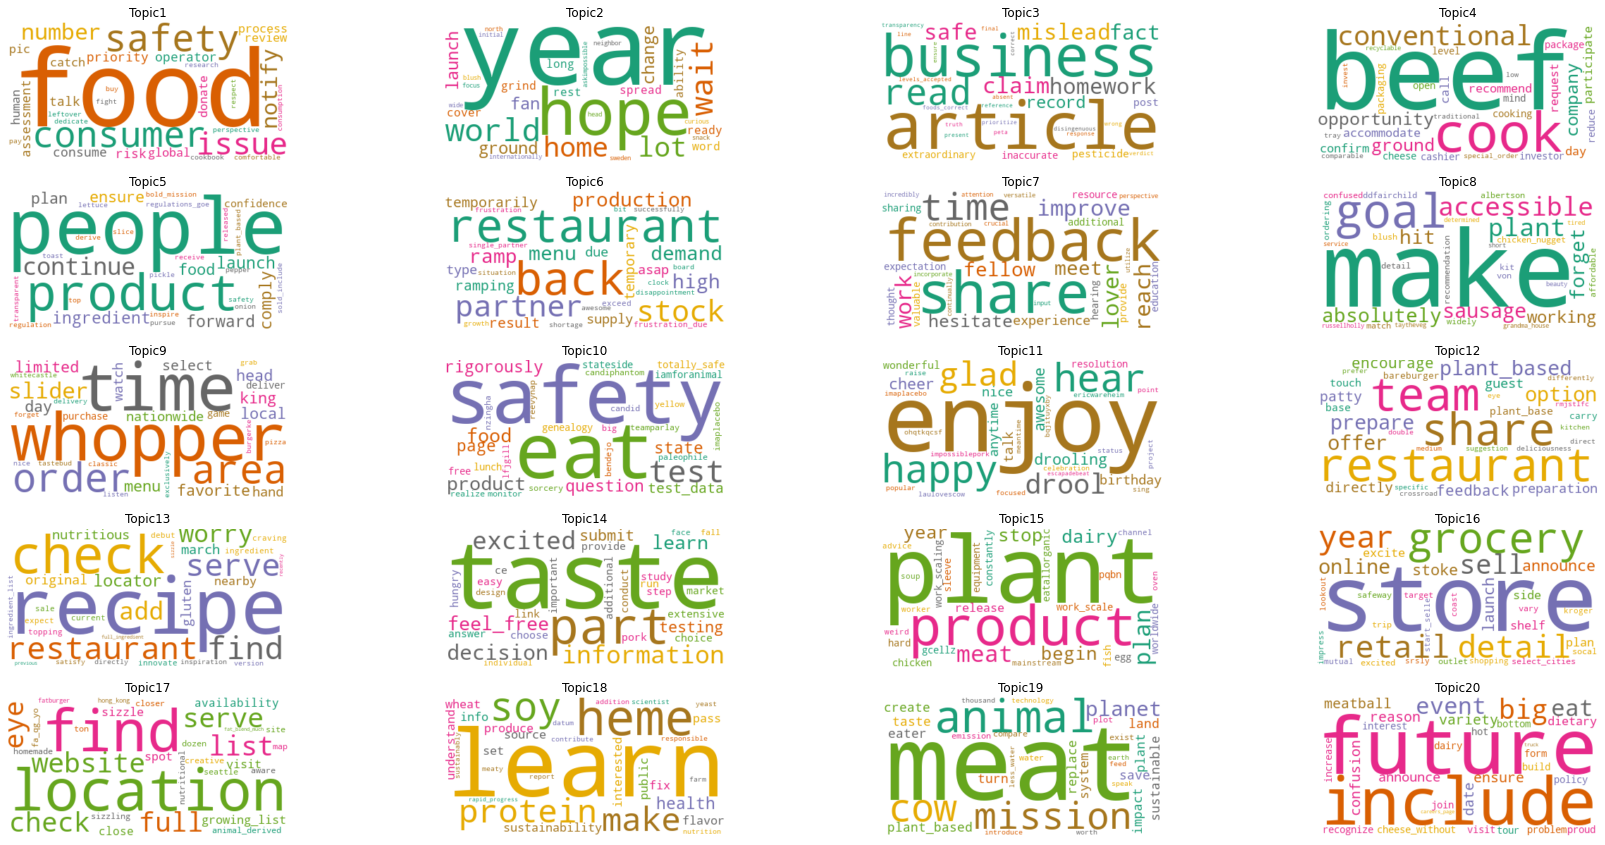

In [ ]:
# Create subplots for each topic
for i in range(30):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

# Dominant Topic Contribution

In [ ]:
# create a dataframe 
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Year'] = df.Year

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df.head()

,Year,Dominant Topic,Contribution %,Topic Terms
0,2017,28,5.77,"hear, love, chance, give, end, roll, psyche, bspotburger, psyched, compliment, thrill, front, teamimpossible, beauty, hate, cue, fantastic, cuisine, covetingcarnage, burps, catastrophic, cute, impression, content, launch, oezbxzuv, pjmcpo, redwood, milkpowderbun, lock"
1,2016,1,3.33,"food, safety, consumer, issue, number, notify, priority, risk, assessment, operator, talk, consume, process, pic, global, review, human, donate, catch, perspective, buy, consumption, comfortable, leftover, research, fight, respect, pay, dedicate, cookbook"
2,2016,19,5.76,"meat, animal, cow, mission, planet, plant_based, taste, plant, save, create, replace, eater, turn, sustainable, land, impact, system, compare, emission, exist, water, plot, technology, less_water, earth, feed, speak, worth, introduce, thousand"
3,2016,25,6.32,"share, impossiblefood, experience, send, connect, contact, email, feel, unable, follow, team, tzkvcjgeji, concern, shoot, discuss, attention, message, situation, dm, material, spice, reply, assist, hopdoddy, reaction, warehouse, natural_flavor, fruit, fortunemagazine, describe"
4,2016,24,8.53,"stay, tune, news, update, timeline, specific, detail, hometown, tuned, exciting, upcoming, cut, sharing, thrill, hoodsavior, recruit, satay, chrisobleness, referenced, prevent, stlstacey, panerabread, cfiguere, neilchawkin, accessibility, veganflawe, enterplayer, tool, hat, mpetricone"


# Dominant Topics Distribution Across Corpus

In [ ]:
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,2723,11.85
1,2,756,3.29
2,3,716,3.12
3,4,656,2.86
4,5,497,2.16
5,6,566,2.46
6,7,704,3.06
7,8,433,1.88
8,9,757,3.29
9,10,405,1.76


In [ ]:
topic_counts = dominant_topic_df[["Dominant Topic", 	"Doc_Count", "Total_Docs_Perc"]]
topic_counts.columns  = ["Dominant Topic", 	"Document Count", "Total Document Percentage"]
topic_counts

,Dominant Topic,Document Count,Total Document Percentage
0,1,2723,11.85
1,2,756,3.29
2,3,716,3.12
3,4,656,2.86
4,5,497,2.16
5,6,566,2.46
6,7,704,3.06
7,8,433,1.88
8,9,757,3.29
9,10,405,1.76


In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)


,Year,Dominant Topic,Contribution %,Topic Terms
0,2019,1,21.86,"food, safety, consumer, issue, number, notify, priority, risk, assessment, operator, talk, consume, process, pic, global, review, human, donate, catch, perspective, buy, consumption, comfortable, leftover, research, fight, respect, pay, dedicate, cookbook"
1,2019,2,19.10,"year, hope, world, wait, lot, home, ground, change, fan, launch, spread, cover, word, long, rest, grind, ability, ready, internationally, focus, north, neighbor, snack, wide, initial, curious, head, blush, sweden, askimpossible"
2,2019,3,22.04,"article, business, read, claim, mislead, homework, safe, fact, record, pesticide, post, extraordinary, inaccurate, levels_accepted, absent, foods_correct, disingenuous, truth, line, final, transparency, peta, prioritize, correct, verdict, present, reference, response, wrong, ensure"
3,2020,4,20.20,"beef, cook, conventional, opportunity, ground, company, accommodate, call, participate, recommend, confirm, request, day, cooking, packaging, cashier, package, open, cheese, reduce, mind, investor, level, special_order, low, invest, traditional, comparable, tray, recyclable"
4,2019,5,24.05,"people, product, continue, ingredient, launch, forward, comply, ensure, food, plan, confidence, regulations_goe, inspire, receive, bold_mission, pursue, safety, top, regulation, sold_include, plant_based, onion, slice, pickle, released, pepper, toast, transparent, derive, lettuce"
5,2019,6,22.74,"restaurant, back, partner, stock, production, demand, ramp, high, menu, temporarily, ramping, result, temporary, supply, asap, due, type, frustration_due, exceed, disappointment, clock, awesome, board, single_partner, shortage, frustration, growth, situation, bit, successfully"
6,2018,7,22.91,"feedback, share, time, improve, reach, lover, work, meet, fellow, hesitate, experience, expectation, additional, resource, sharing, provide, hearing, education, thought, valuable, perspective, utilize, incorporate, crucial, contribution, input, incredibly, continually, attention, versatile"
7,2020,8,12.14,"make, goal, accessible, plant, sausage, absolutely, hit, forget, working, chicken_nugget, blush, confused, albertson, widely, recommendation, detail, von, match, ordering, affordable, kit, ddfairchild, grandma_house, service, short, russellholly, tired, beauty, determined, taytheveg"
8,2020,9,16.49,"whopper, time, order, area, slider, favorite, day, head, king, local, limited, menu, select, nationwide, hand, watch, purchase, game, deliver, delivery, whitecastle, forget, burgerke, exclusively, listen, tastebud, grab, classic, pizza, nice"
9,2019,10,22.57,"safety, eat, test, product, food, question, page, state, rigorously, test_data, totally_safe, stateside, free, genealogy, lunch, iamforanimal, candiphantom, teamparlay, paleophile, imaplacebo, sorcery, lfjgill, big, nzingha, monitor, bendejo, realize, yellow, candid, reevynap"


In [ ]:
tm_results = ldamallet[corpus]

In [ ]:
pprint(tm_results[0])

[(0, 0.03205128205128204),
 (1, 0.03205128205128204),
 (2, 0.03205128205128204),
 (3, 0.03205128205128204),
 (4, 0.03205128205128204),
 (5, 0.03205128205128204),
 (6, 0.03205128205128204),
 (7, 0.03205128205128204),
 (8, 0.03205128205128204),
 (9, 0.03205128205128204),
 (10, 0.03632478632478632),
 (11, 0.03205128205128204),
 (12, 0.03205128205128204),
 (13, 0.03205128205128204),
 (14, 0.03205128205128204),
 (15, 0.03205128205128204),
 (16, 0.03205128205128204),
 (17, 0.03205128205128204),
 (18, 0.03205128205128204),
 (19, 0.03205128205128204),
 (20, 0.03205128205128204),
 (21, 0.03205128205128204),
 (22, 0.03205128205128204),
 (23, 0.03205128205128204),
 (24, 0.03205128205128204),
 (25, 0.03205128205128204),
 (26, 0.03205128205128204),
 (27, 0.05769230769230769),
 (28, 0.03205128205128204),
 (29, 0.0405982905982906)]


In [ ]:
df_weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_weights.columns = ['Topic ' + str(i) for i in range(1,31)]
df_weights

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598
1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864
3,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736
4,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22971,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051
22972,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.048218,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.046122,0.031447,0.031447,0.033543,0.035639,0.031447,0.031447,0.050314,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447
22973,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.059829,0.032051,0.042735
22974,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051


In [ ]:
df_weights['Year'] = df.Year.astype(int)
df_weights


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Year
0,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598,2017
1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,2016
2,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,2016
3,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736,2016
4,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22971,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021
22972,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.048218,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.046122,0.031447,0.031447,0.033543,0.035639,0.031447,0.031447,0.050314,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,2021
22973,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.059829,0.032051,0.042735,2021
22974,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021


In [ ]:
df_weights.groupby('Year').mean()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016,0.032883,0.036294,0.032335,0.031799,0.033134,0.032322,0.033076,0.032733,0.032227,0.031926,0.034272,0.033733,0.032982,0.032439,0.032352,0.033753,0.033111,0.031832,0.032453,0.034636,0.035839,0.033969,0.033356,0.037230,0.032921,0.033136,0.035617,0.032349,0.033155,0.032136
2017,0.032195,0.037023,0.031708,0.032611,0.032132,0.032213,0.035281,0.032176,0.032782,0.031484,0.035493,0.034772,0.032417,0.033114,0.032670,0.032991,0.033573,0.032870,0.033580,0.032325,0.033015,0.032649,0.032851,0.034382,0.032449,0.032642,0.036760,0.034435,0.033804,0.033603
2018,0.032264,0.032874,0.036637,0.032001,0.035774,0.031487,0.034762,0.033295,0.032298,0.031890,0.034627,0.033614,0.032031,0.032440,0.033139,0.033393,0.034813,0.032555,0.032423,0.032109,0.034018,0.031774,0.032227,0.033551,0.033097,0.033864,0.033257,0.033797,0.035648,0.034340
2019,0.033312,0.032851,0.032307,0.033152,0.032654,0.035531,0.033774,0.032920,0.033182,0.036388,0.032628,0.032494,0.033869,0.032728,0.033901,0.033792,0.033326,0.033190,0.032885,0.033464,0.033008,0.032074,0.032840,0.034083,0.033774,0.032642,0.032640,0.033585,0.033539,0.033466
2020,0.033170,0.032883,0.032056,0.034413,0.032273,0.031888,0.032208,0.033739,0.034309,0.032050,0.032559,0.032847,0.033270,0.034495,0.033287,0.033930,0.033249,0.033534,0.034868,0.033448,0.032769,0.037109,0.034905,0.033056,0.033278,0.033712,0.033612,0.032287,0.032483,0.032314
2021,0.033099,0.032621,0.032140,0.034148,0.032530,0.031849,0.032860,0.034664,0.033540,0.032233,0.033169,0.033095,0.034152,0.034085,0.034231,0.032738,0.033313,0.033942,0.034428,0.033898,0.034150,0.035752,0.034795,0.031640,0.033416,0.033519,0.032602,0.032829,0.031857,0.032705


In [ ]:
df_weights

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Year
0,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598,2017
1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,2016
2,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,2016
3,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736,2016
4,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22971,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021
22972,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.048218,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.046122,0.031447,0.031447,0.033543,0.035639,0.031447,0.031447,0.050314,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,2021
22973,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.059829,0.032051,0.042735,2021
22974,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021


In [ ]:
df_weights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22976 entries, 0 to 22975
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Topic 1   22976 non-null  float64
 1   Topic 2   22976 non-null  float64
 2   Topic 3   22976 non-null  float64
 3   Topic 4   22976 non-null  float64
 4   Topic 5   22976 non-null  float64
 5   Topic 6   22976 non-null  float64
 6   Topic 7   22976 non-null  float64
 7   Topic 8   22976 non-null  float64
 8   Topic 9   22976 non-null  float64
 9   Topic 10  22976 non-null  float64
 10  Topic 11  22976 non-null  float64
 11  Topic 12  22976 non-null  float64
 12  Topic 13  22976 non-null  float64
 13  Topic 14  22976 non-null  float64
 14  Topic 15  22976 non-null  float64
 15  Topic 16  22976 non-null  float64
 16  Topic 17  22976 non-null  float64
 17  Topic 18  22976 non-null  float64
 18  Topic 19  22976 non-null  float64
 19  Topic 20  22976 non-null  float64
 20  Topic 21  22976 non-null  fl

In [ ]:
df_weights['Year'] = pd.to_numeric(df_weights['Year'])

In [ ]:
df_weights.dropna()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Year
0,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598,2017
1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,2016
2,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,2016
3,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736,2016
4,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22971,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021
22972,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.048218,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.046122,0.031447,0.031447,0.033543,0.035639,0.031447,0.031447,0.050314,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,0.031447,2021
22973,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.059829,0.032051,0.042735,2021
22974,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.051282,0.051282,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,2021


In [ ]:
df_weights['Dominant'] = df_weights.drop('Year', axis=1).idxmax(axis=1)

In [ ]:
df_weights.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Year,Dominant
0,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598,2017,Topic 28
1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,2016,Topic 1
2,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,2016,Topic 19
3,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736,2016,Topic 25
4,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746,2016,Topic 24


In [ ]:
df_weights.to_csv('df_weights.csv')

In [ ]:
df_weights.groupby('Year')['Dominant'].value_counts(normalize=True)

Year  Dominant
2016  Topic 11    0.121387
      Topic 24    0.115607
      Topic 2     0.098266
      Topic 1     0.092486
      Topic 21    0.057803
                    ...   
2021  Topic 5     0.013384
      Topic 6     0.009560
      Topic 29    0.008604
      Topic 10    0.008126
      Topic 24    0.008126
Name: Dominant, Length: 179, dtype: float64

In [ ]:
df_weights.groupby('Year')['Dominant'].value_counts(normalize=True).to_excel('fromImpossible_weights by year.xlsx')

In [ ]:
df_dominance = df_weights.groupby('Year')['Dominant'].value_counts(normalize=True).unstack()
df_dominance

Dominant,Topic 1,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 2,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 3,Topic 30,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016,0.092486,0.005780,0.121387,0.011561,0.011561,0.028902,0.005780,0.040462,0.011561,0.005780,0.023121,0.098266,0.046243,0.057803,0.040462,0.046243,0.115607,0.028902,0.040462,0.028902,0.005780,0.017341,0.011561,NaN,0.023121,0.005780,0.005780,0.005780,0.040462,0.023121
2017,0.117698,0.002616,0.116827,0.045336,0.010898,0.025283,0.012206,0.017437,0.036181,0.023540,0.031822,0.078466,0.013514,0.025719,0.022668,0.034438,0.054490,0.014821,0.027899,0.068875,0.047079,0.025283,0.012206,0.019616,0.017873,0.005231,0.006975,0.055798,0.005231,0.023976
2018,0.093629,0.001628,0.095461,0.021779,0.006920,0.018115,0.015673,0.027478,0.058620,0.014044,0.018115,0.032567,0.010584,0.034399,0.013841,0.028496,0.031142,0.032160,0.062894,0.020761,0.046407,0.038876,0.072461,0.058824,0.012009,0.046815,0.004478,0.044372,0.014451,0.023000
2019,0.117293,0.035811,0.045153,0.011625,0.028752,0.023355,0.023770,0.039132,0.029998,0.025950,0.022836,0.027092,0.024497,0.019307,0.022109,0.043077,0.036952,0.038406,0.041208,0.016193,0.053041,0.027507,0.022732,0.047540,0.029168,0.018995,0.048578,0.029375,0.015570,0.034980
2020,0.143669,0.007235,0.045736,0.017054,0.021964,0.044186,0.022222,0.035142,0.027649,0.029199,0.052972,0.021964,0.027649,0.017571,0.072351,0.065375,0.025323,0.027132,0.040568,0.027132,0.017829,0.020155,0.019121,0.017313,0.048320,0.011111,0.010078,0.009561,0.028165,0.046253
2021,0.139101,0.008126,0.054493,0.021033,0.035373,0.039197,0.024379,0.017686,0.031071,0.027247,0.043977,0.025335,0.029159,0.037763,0.065488,0.069790,0.008126,0.033461,0.041587,0.015296,0.029159,0.008604,0.017686,0.022945,0.040153,0.013384,0.009560,0.017686,0.040153,0.032983


In [ ]:
df_weights["Month"] = df.Month

In [ ]:
df_months = df_weights.groupby(['Year', 'Month'])['Dominant'].value_counts(normalize=True).unstack()
df_months.head(15)

Dominant     Topic 1  Topic 10  Topic 11  ...   Topic 7   Topic 8   Topic 9
Year Month                                ...                              
2016 2     NaN       NaN       NaN        ... NaN       NaN       NaN      
     4     NaN       NaN       NaN        ... NaN       NaN       NaN      
     5     NaN       NaN       NaN        ... NaN       NaN       NaN      
     8      0.222222 NaN       NaN        ... NaN       NaN        0.111111
     9      0.071429 NaN       NaN        ... NaN        0.071429 NaN      
     10     0.121951 NaN        0.097561  ...  0.024390  0.048780 NaN      
     11     0.080645  0.016129  0.225806  ... NaN        0.016129 NaN      
     12     0.071429 NaN        0.107143  ... NaN        0.071429  0.107143
2017 1     NaN       NaN        0.213115  ...  0.032787 NaN       NaN      
     2      0.027397 NaN        0.068493  ... NaN        0.013699  0.027397
     3      0.051471 NaN        0.154412  ...  0.007353  0.007353 NaN      
     4      0.033898  0.016949  0.254237  ... NaN       NaN       NaN      
     5      0.055556 NaN        0.122222  ...  0.033333  0.011111  0.011111
     6      0.035714 NaN        0.178571  ...  0.119048 NaN        0.035714
     7      0.076433  0.006369  0.229299  ...  0.038217 NaN        0.006369

[15 rows x 30 columns]

In [ ]:
df_months.to_excel('year and month dominant topic.xlsx')

In [ ]:
df_months.reset_index(inplace=True)

In [ ]:
df_months

Dominant,Year,Month,Topic 1,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 2,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 3,Topic 30,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2016,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
1,2016,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN
2,2016,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,8,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.111111,0.111111,0.111111,NaN,NaN,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.111111
4,2016,9,0.071429,NaN,NaN,0.035714,NaN,0.142857,0.035714,0.142857,NaN,NaN,NaN,0.142857,NaN,0.071429,0.071429,NaN,0.035714,0.071429,NaN,NaN,NaN,0.035714,0.071429,NaN,NaN,NaN,NaN,NaN,0.071429,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2021,8,0.154762,0.011905,0.071429,0.035714,0.059524,0.023810,0.047619,0.035714,0.011905,0.011905,0.035714,0.011905,0.023810,0.023810,0.035714,0.083333,NaN,NaN,0.071429,NaN,0.023810,NaN,0.011905,0.047619,0.059524,NaN,0.011905,NaN,0.071429,0.023810
64,2021,9,0.148718,NaN,0.046154,0.030769,0.020513,0.082051,0.005128,0.020513,0.066667,0.020513,0.030769,0.020513,0.025641,0.051282,0.046154,0.056410,0.010256,0.025641,0.030769,0.020513,0.046154,0.015385,0.025641,0.025641,0.020513,0.005128,0.015385,0.025641,0.046154,0.015385
65,2021,10,0.148515,0.009901,0.054455,0.014851,0.039604,0.059406,0.044554,0.029703,0.014851,0.019802,0.049505,0.034653,0.029703,0.024752,0.034653,0.049505,0.009901,0.014851,0.024752,0.009901,0.029703,0.004950,0.034653,0.029703,0.044554,0.014851,0.009901,0.009901,0.074257,0.029703
66,2021,11,0.174863,0.016393,0.054645,0.038251,0.016393,0.032787,0.016393,0.021858,0.038251,0.016393,0.027322,0.016393,0.021858,0.060109,0.065574,0.092896,0.016393,0.016393,0.043716,NaN,0.010929,NaN,0.032787,0.027322,0.032787,0.021858,NaN,0.027322,0.032787,0.027322


In [ ]:
df_melted = df_months.melt(id_vars=['Year', 'Month'], value_vars=['Topic ' + str(i) for i in range(1,11)], var_name='Topic', value_name='Prevelance')

In [ ]:
df_melted

,Year,Month,Topic,Prevelance
0,2016,2,Topic 1,NaN
1,2016,4,Topic 1,NaN
2,2016,5,Topic 1,NaN
3,2016,8,Topic 1,0.222222
4,2016,9,Topic 1,0.071429
...,...,...,...,...
675,2021,8,Topic 10,0.011905
676,2021,9,Topic 10,NaN
677,2021,10,Topic 10,0.009901
678,2021,11,Topic 10,0.016393


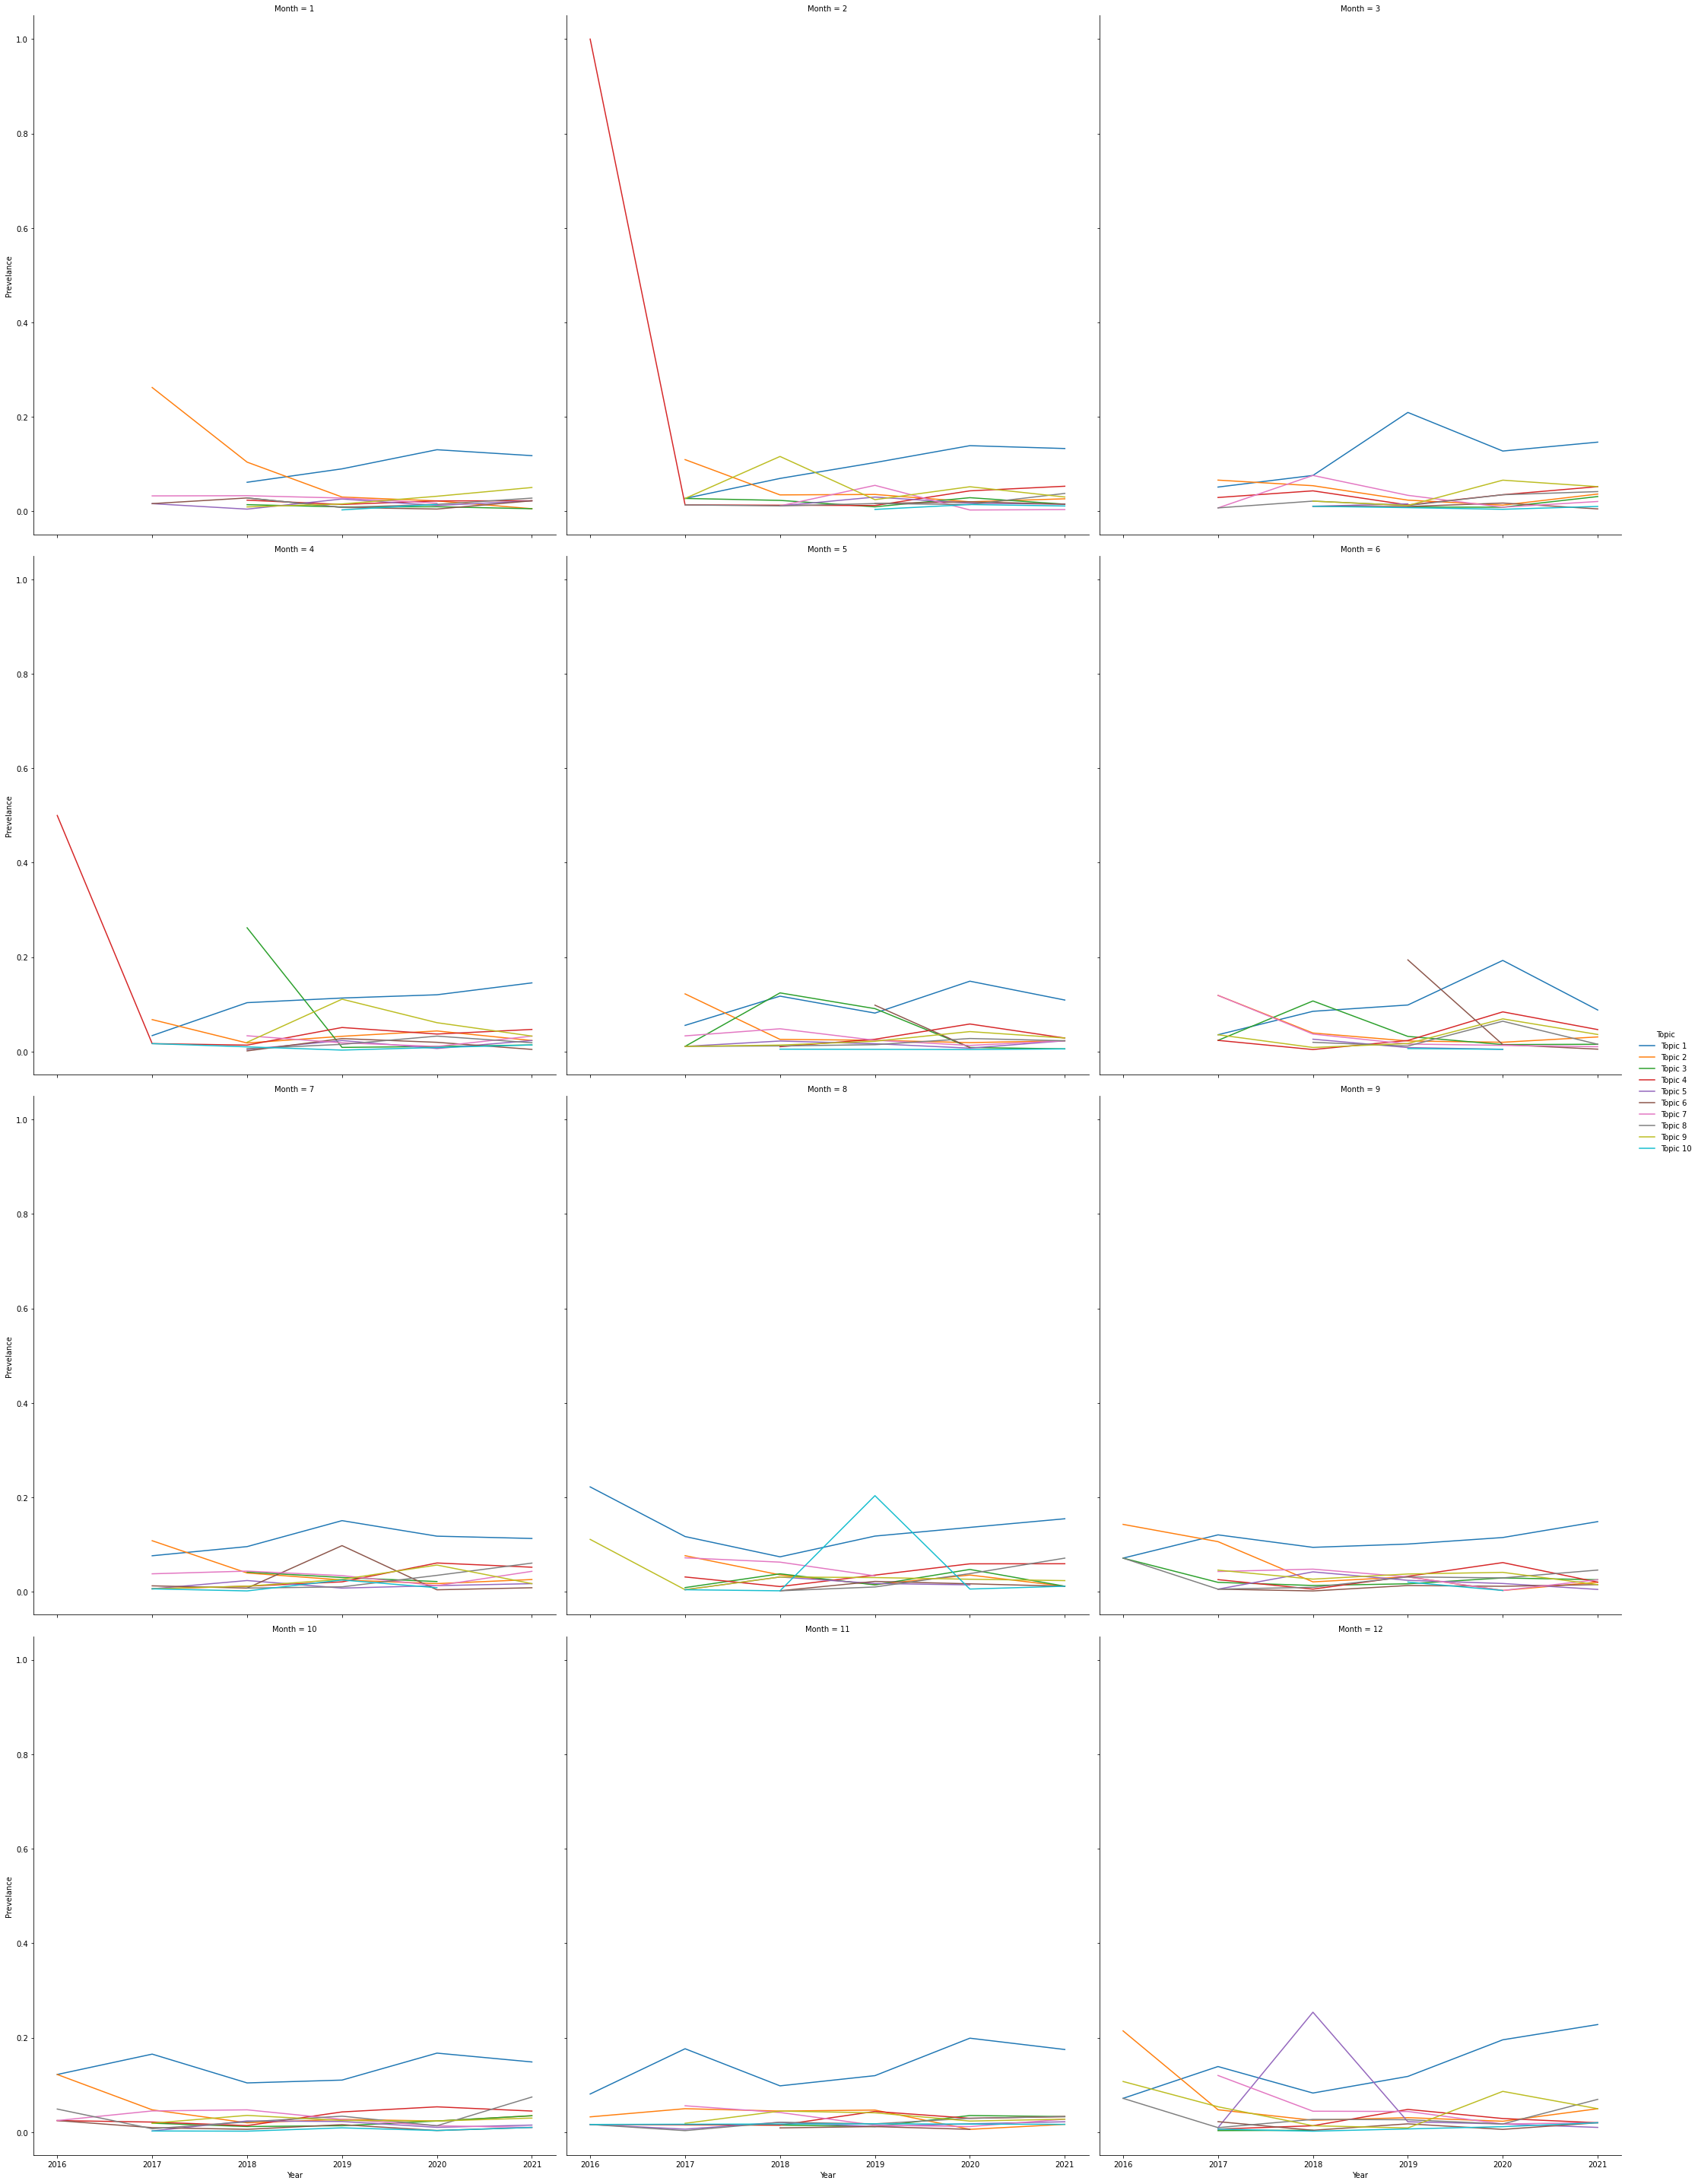

In [ ]:
sns.relplot(x='Year', y="Prevelance", col="Month", col_wrap=3, hue='Topic',
data=df_melted,
kind="line",
height=10,
style="Topic",
dashes=False,
ci=None);

In [ ]:
df_months.set_index(['Year', 'Month'], inplace=True)

In [ ]:
# set the figure size
plt.rcParams['figure.figsize'] = [10, 6]

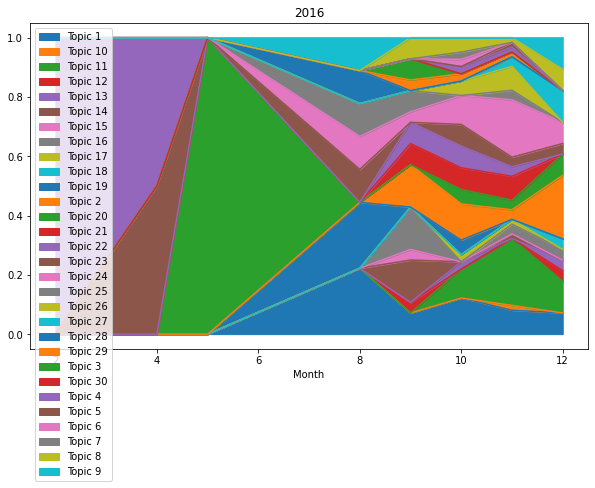

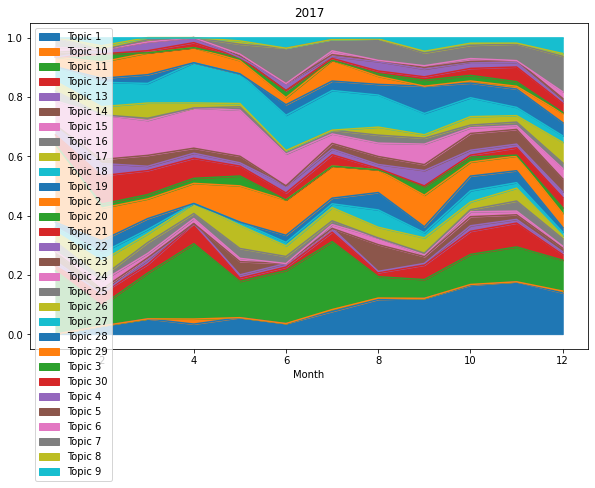

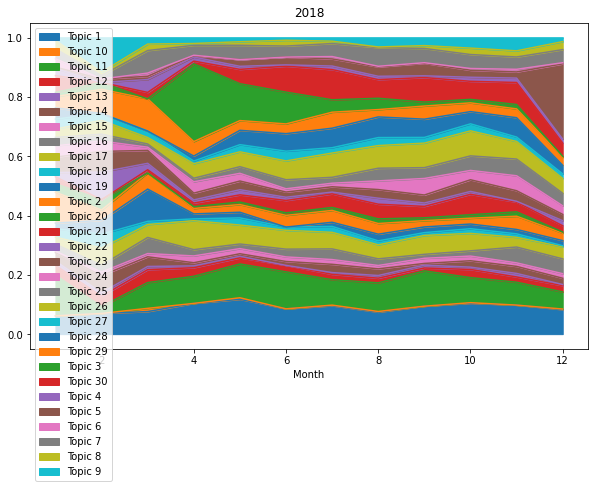

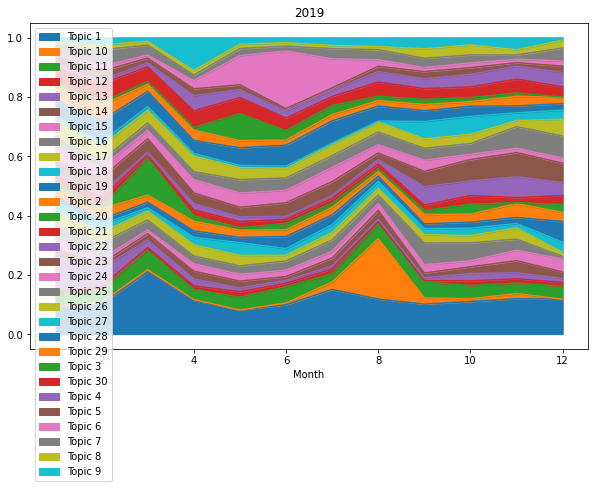

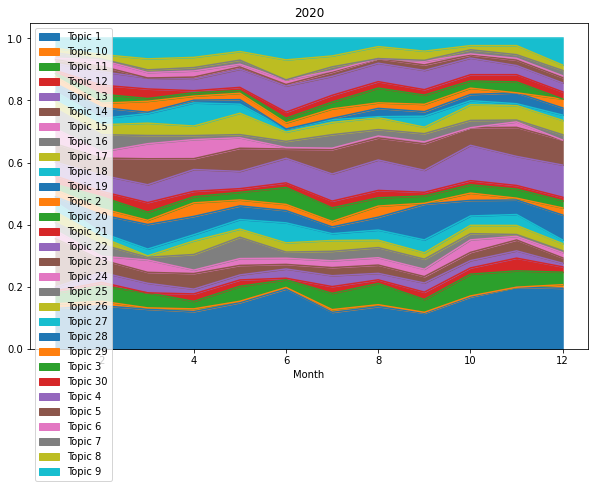

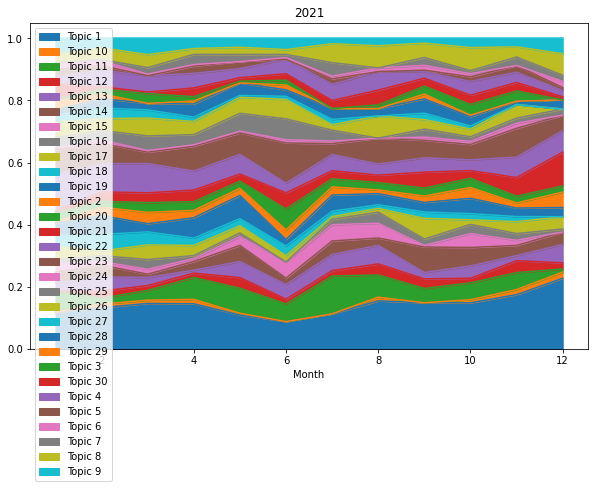

In [ ]:
for m in df_months.index.levels[0]:
  df_months.xs(m, level=0).plot.area()
  plt.title(m)
  plt.legend(loc='upper left')

plt.show()

# Coherence Calculatation

In [ ]:
# display a progress meter
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary, iterations=500, workers=cpus)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus, texts=data_ready, dictionary=id2word,
                                                               start_topic_count=2, end_topic_count=50, step=2, cpus=16)

100%|██████████| 25/25 [11:23<00:00, 27.34s/it]


In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 51, 2), 'Coherence Score': np.round(coherence_scores, 4)})

#coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

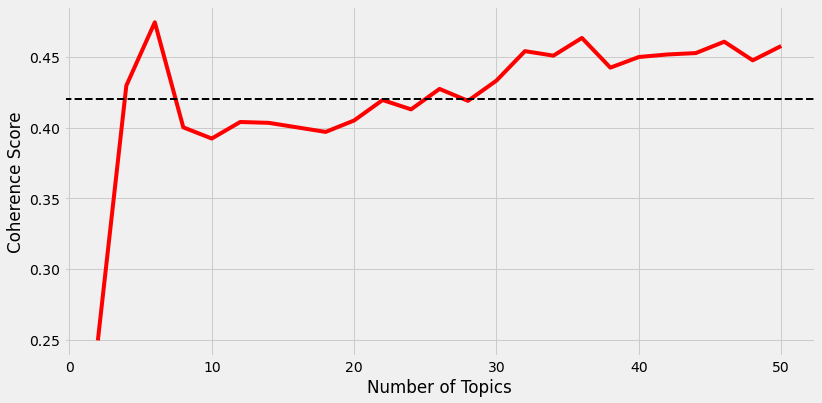

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


x_ax = range(2, 51, 2)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.42, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

# pyLDAvis intertopic distance map

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

In [ ]:
vis.topic_info.to_excel('pyldavis_wordfreq_gen_2020-14.xlsx')

# Heatmap

In [ ]:
!pip install calplot

In [ ]:
# import data
# upload file
uploaded = files.upload()

Saving fromImpossibleFoods_all_timeseries.csv to fromImpossibleFoods_all_timeseries.csv


In [ ]:
# Read data into dataframe
df = pd.read_csv('/fromImpossibleFoods_all_timeseries.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22976 entries, 0 to 22975
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      22976 non-null  object 
 1   Topic 1   22976 non-null  float64
 2   Topic 2   22976 non-null  float64
 3   Topic 3   22976 non-null  float64
 4   Topic 4   22976 non-null  float64
 5   Topic 5   22976 non-null  float64
 6   Topic 6   22976 non-null  float64
 7   Topic 7   22976 non-null  float64
 8   Topic 8   22976 non-null  float64
 9   Topic 9   22976 non-null  float64
 10  Topic 10  22976 non-null  float64
 11  Topic 11  22976 non-null  float64
 12  Topic 12  22976 non-null  float64
 13  Topic 13  22976 non-null  float64
 14  Topic 14  22976 non-null  float64
 15  Topic 15  22976 non-null  float64
 16  Topic 16  22976 non-null  float64
 17  Topic 17  22976 non-null  float64
 18  Topic 18  22976 non-null  float64
 19  Topic 19  22976 non-null  float64
 20  Topic 20  22976 non-null  fl

In [ ]:
#change the type of data
df['Date'] = pd.to_datetime(df['Date'])
#Set orderdate as index
df.set_index('Date', inplace = True)

/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

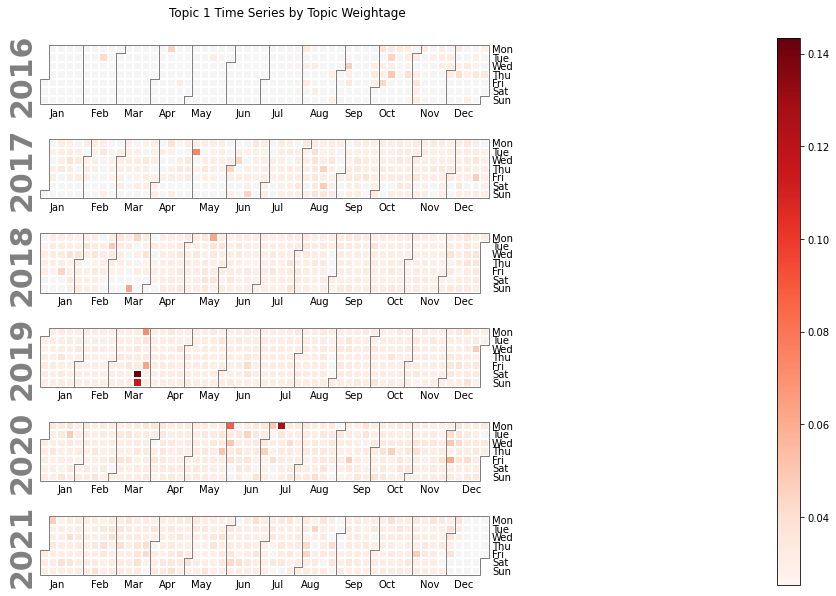

In [ ]:
import calplot
pl1 = calplot.calplot(data = df['Topic 1'],how = 'mean', cmap = 'Reds', figsize = (16, 8), suptitle = "Topic 1 Time Series by Topic Weightage")

/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

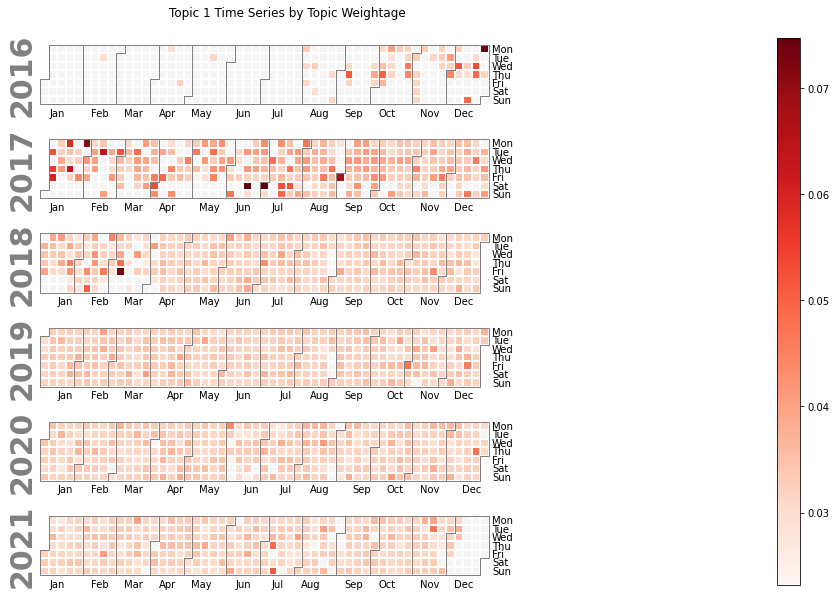

In [ ]:
import calplot
pl1 = calplot.calplot(data = df['Topic 2'],how = 'mean', cmap = 'Reds', figsize = (16, 8), suptitle = "Topic 1 Time Series by Topic Weightage")

/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

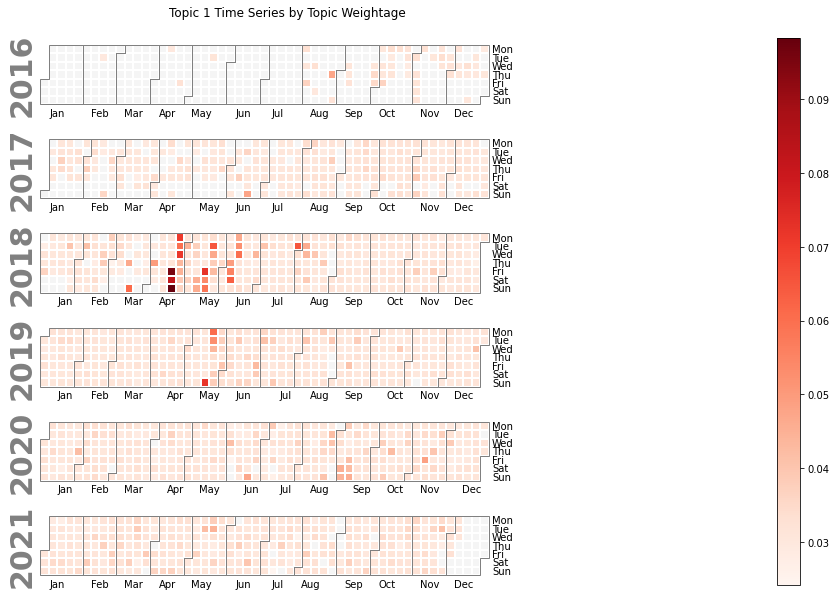

In [ ]:
import calplot
pl1 = calplot.calplot(data = df['Topic 3'],how = 'mean', cmap = 'Reds', figsize = (16, 8), suptitle = "Topic 1 Time Series by Topic Weightage")

/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

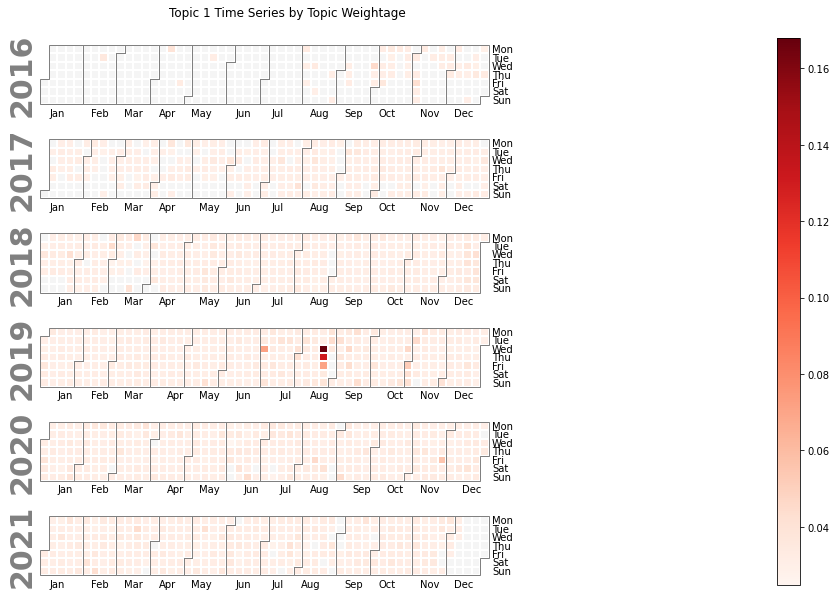

In [ ]:
import calplot
pl1 = calplot.calplot(data = df['Topic 10'],how = 'mean', cmap = 'Reds', figsize = (16, 8), suptitle = "Topic 1 Time Series by Topic Weightage")

/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  for i in monthticks])
/usr/local/lib/python3.7/dist-packages/calplot/calplot.py:191: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in 

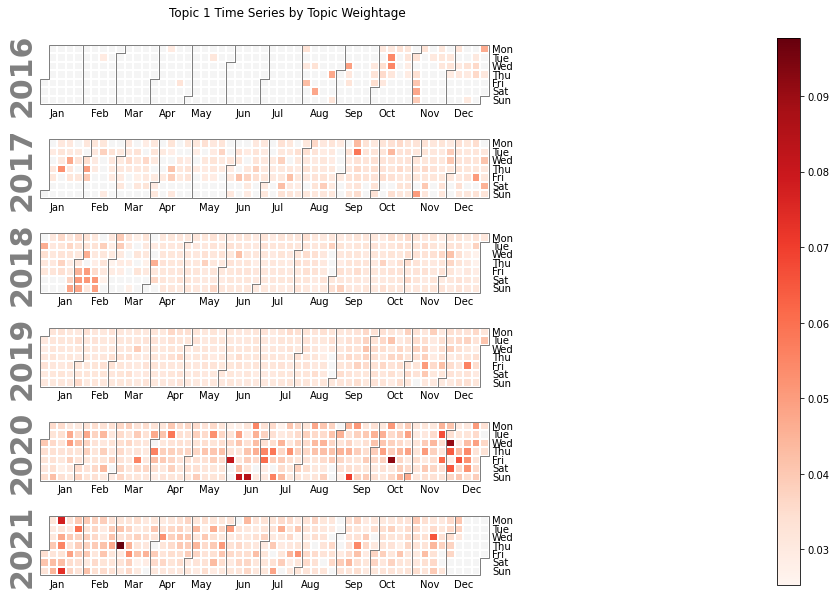

In [ ]:
import calplot
pl1 = calplot.calplot(data = df['Topic 22'],how = 'mean', cmap = 'Reds', figsize = (16, 8), suptitle = "Topic 1 Time Series by Topic Weightage")

# Heatmap 2

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [ ]:
# Configuration parameters
# The path to the output folder where all the outputs will be saved
output_path = "/content/gdrive/MyDrive"

In [ ]:
num_topics = 30

tweet_num = pd.read_csv("/fromImpossibleFoods_all_timeseries.csv")
tweet_num.head()

,Date,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30
0,2017-02-01 22:07:28+00:00,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.036325,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.057692,0.032051,0.040598
1,2016-08-01 05:13:16+00:00,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2,2016-08-03 21:34:47+00:00,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.049383,0.030864,0.030864,0.030864,0.049383,0.030864,0.032922,0.030864,0.039095,0.030864,0.030864,0.030864,0.057613,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864,0.030864
3,2016-08-05 19:12:49+00:00,0.028736,0.028736,0.047893,0.042146,0.028736,0.028736,0.036398,0.028736,0.038314,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.028736,0.030651,0.045977,0.028736,0.028736,0.061303,0.028736,0.028736,0.063218,0.030651,0.028736,0.028736,0.028736,0.028736
4,2016-08-05 01:28:22+00:00,0.029762,0.033730,0.029762,0.029762,0.039683,0.029762,0.039683,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.047619,0.031746,0.033730,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.029762,0.085317,0.029762,0.029762,0.029762,0.031746,0.029762,0.031746


## Number of articles per day

In [ ]:
tweets_per_day = tweet_num[["Date", "Topic 1"]].copy()
tweets_per_day["n_tweets"] = 1
tweets_per_day = tweets_per_day.groupby("Date").agg({
    "Topic": lambda x: list(x),
    "n_tweets": lambda x: sum(x)
}).reset_index(drop=False)
tweets_per_day["Topic"] = tweets_per_day["Topic 1"].apply(lambda x: list(set(x)))
tweets_per_day["n_topics"] = tweets_per_day["Topic 1"].apply(len)
tweets_per_day.head()

KeyError: ignored